# Simulating capillary pressure curves using Porosimetry

Start by importing OpenPNM.

In [1]:
import numpy as np
import openpnm as op
np.random.seed(10)
ws = op.Workspace()
ws.settings["loglevel"] = 40
np.set_printoptions(precision=5)

Next, create a simple cubic network with 20 pores per side and a spacing of 50 um

In [2]:
pn = op.network.Cubic(shape=[20, 20, 20], spacing=0.00005)

The network object only contains topological and spatial information.  We need to assign some pore and throat sizes, which can be conveniently done by creating a ``StickAndBall`` geometry object.

In [3]:
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

The ``StickAndBall`` class assigns pores as random values between 0.2 and 0.7 of the lattice spacing, then finds all other geometric information assuming the pores are spheres and the throats are cylinders.

Next we need to create a phase object which contains the thermo-physical properties of the invading fluid, such as surface tension:

In [4]:
hg = op.phases.Mercury(network=pn, name='mercury')

Lastly, we need to compute the capillary entry pressure of the throats in the network.  The OpenPNM ``models`` library has a few common capillary pressure models, including the Washburn equation:

$$ P_C = \frac{-2\sigma cos(\theta)}{R_T} $$

To use this model we should create a physics object, and use the ``add_model`` method as follows:

In [5]:
phys = op.physics.GenericPhysics(network=pn, phase=hg, geometry=geo)
phys.add_model(propname='throat.entry_pressure',
               model=op.models.physics.capillary_pressure.washburn)

Note that we can inspect our ``project`` to see the interrelationships between all the object with:

In [6]:
print(pn.project.grid)

+Project: sim_01-----------+
|   net_01   |   mercury   |
+------------+-------------+
|   geo_01   |   phys_01   |
+------------+-------------+


The `grid` shows us that `phys_01` is associated with the `mercury` phase, and `geo_01`.  This means that when calculating the throat entry pressure using the Washburn equation above, it will fetch the throat radius ($R_T$) from `geo_01` and the surface tension and contact angle from `mercury`.

Now that all the required objects are setup, we can perform the capillary pressure curve simulation.  OpenPNM contains both InvasionPercolation and OrdinaryPercolation classes.  The porosimetry experiment is ordinary percolation with access limitations.  This means that a fixed pressure is applied to the invading fluid and all pores and throat that can be penetrated at that pressure are set as *possibly* invaded, *then* pores and throats are set to invaded only if they are physically connected to the source of invading fluid directly or though a path of already invading pores and throats.  Since this process is simulated very frequently, OpenPNM includes a class called Porosimetry that is a subclass of OrdinaryPercolation, with several useful methods added.  It's use is illustrated below:

In [7]:
mip = op.algorithms.Porosimetry(network=pn, phase=hg)
mip.set_inlets(pores=pn.pores('left'))
mip.run()

The meaning of this warning message will be analyzed below, but first let's take a quick look at the result using the built-in plotting method:

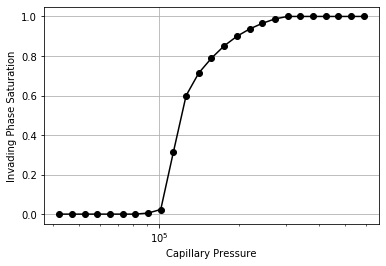

In [8]:
#NBVAL_IGNORE_OUTPUT
fig = mip.plot_intrusion_curve()

In [9]:
Pc, Snwp = mip.get_intrusion_data()
print(Pc, Snwp)

[ 42142.40196  47030.17163  52484.83572  58572.14391  65365.47166
  72946.7047   81407.22604  90849.0175  101385.88896 113144.85026
 126267.64209 140912.44455 157255.78382 175494.66001 195848.92168
 218563.91598 243913.44593 272203.07084 303773.78948 339006.15041
 378324.83906 422203.79682 471171.93387 525819.50455 586805.22225] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005334441584444236, 0.023349429373502786, 0.3147532781513407, 0.5996633921017048, 0.7140589551194284, 0.7890446004531194, 0.8510852707172183, 0.8993157761187267, 0.9363213760435675, 0.9649411782335564, 0.9873089340667308, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


With the above data in the form of arrays it's possible to cut&paste into Excel, or to use a Python plotting package such as Matplotlib to make plots with your desired style:

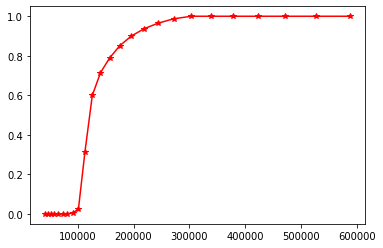

In [10]:
#NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt
fig = plt.plot(Pc, Snwp, 'r*-')